Student: Gabriel Martins de Andrade

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

The optimization problem under constraints is equivalent to:
$$
\left\{
\begin{array}{l}
    \displaystyle \mathop{\mathrm{argmin}}_{\mathbf{w} \in \mathcal{H}, \, w_0 \in \mathbb{R}, \, \xi \in \mathbb{R}^n} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
    \forall i, \quad \xi_i \ge 0 \\
    \forall i, \quad \xi_i \ge 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)
\end{array}
\right.
$$
For the optimal $\xi$, we can rewrite it as:
$$
\displaystyle \mathop{\mathrm{argmin}}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R}} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \max(0, 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0))
$$
That is equivalent of what the question gave

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div> The sentence "an SVM minimizes the classification error using a convex upper bound" refers to the fact that SVM employ a convex loss function, the hinge loss, to approximate the binary classification error. The main idea behind SVM is to find a decision boundary that maximizes the margin between the positive and negative examples.
The pivotal/hinge loss is a continuous and convex surrogate for the binary classification loss, allowing SVM to efficiently optimize the classification error with respect to the decision boundary. The hinge loss is more sensitive to examples near the decision boundary, promoting the maximization of the margin between classes. On the other hand, the binary loss is discrete, non-convex.

## Example of using the SVC class from scikit-learn

In [ ]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 1.0
Testing score : 0.95


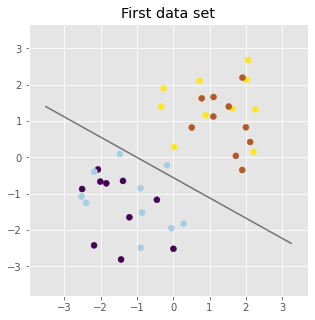

In [ ]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

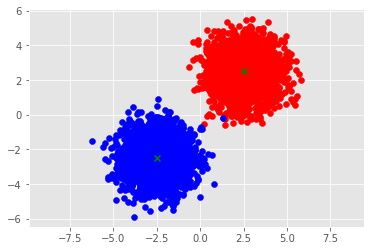

In [ ]:
# Create two centers for the two distributions
centers = [(-2.5, -2.5), (2.5, 2.5)]

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(n_samples=5000, centers=centers, random_state=0)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.scatter(centers[0][0],centers[0][1], marker='x', c='green', cmap=plt.cm.Paired)
plt.scatter(centers[1][0],centers[1][1], marker='x', c='green', cmap=plt.cm.Paired)
plt.axis('equal')
plt.show()

In [ ]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use
# to approximate the integral of the Bayes risk
n_mc = 10000 # Repeat this n_mc times - enough to approximate
expectation = 0
cov = np.eye(2) #standard deviation = 1
for i in range(n_mc):
    rand = np.random.randint(2)# Random binary choice: will the point be generated from the first or second gaussian?
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0],cov)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1],cov)

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x,mean = centers[0], cov=cov)
    p2 = multivariate_normal.pdf(x,mean = centers[1], cov=cov)
    # Compute the risk from these and add it to the total
    risk = min(p1/(p1+p2), p2/(p1+p2))
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.0
Estimated Bayes accuracy: 1.0


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

C = 0.01
Train/Test scores: 0.9997333333333334/0.9992


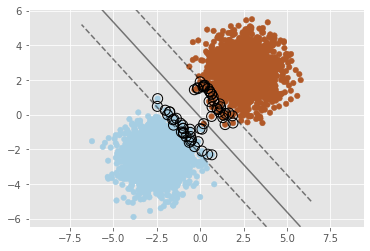

C = 0.1
Train/Test scores: 0.9997333333333334/0.9992


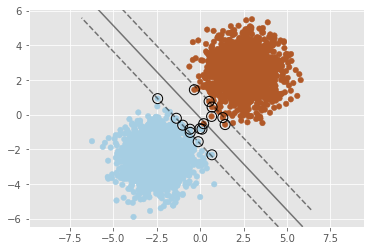

C = 1
Train/Test scores: 0.9997333333333334/0.9992


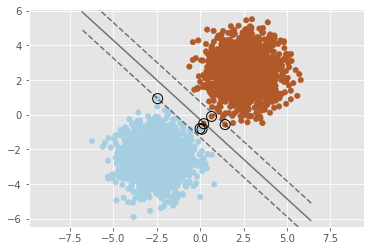

C = 10
Train/Test scores: 1.0/0.9992


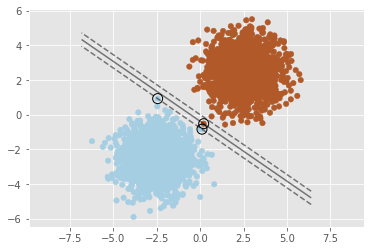

In [ ]:
# Create a linear SVM and train it on the training data
for c in [0.01, 0.1, 1, 10]:
  print('C =',c)
  clf = svm.SVC(kernel="linear", C=c)
  clf.fit(X_train, y_train)

  print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

  # Plot the data
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

  # plot the decision function
  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()

  # create grid to evaluate model
  xx = np.linspace(xlim[0], xlim[1], 30)
  yy = np.linspace(ylim[0], ylim[1], 30)
  YY, XX = np.meshgrid(yy, xx)
  xy = np.vstack([XX.ravel(), YY.ravel()]).T
  Z = clf.decision_function(xy).reshape(XX.shape)

  # plot decision boundary and margins
  ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
  # plot support vectors
  ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k')

  plt.axis('equal')
  plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

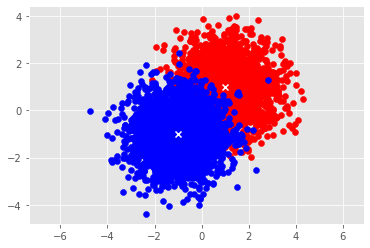

In [ ]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
centers_overlap = [(-1, -1), (1, 1)]
X_overlap, y_overlap = make_blobs(n_samples=5000, centers=centers_overlap, random_state=0)
# Plot the overlapping data
pos_overlap = np.where(y_overlap == 1)[0]
neg_overlap = np.where(y_overlap == 0)[0]
plt.scatter(X_overlap[pos_overlap, 0], X_overlap[pos_overlap, 1], c='r')
plt.scatter(X_overlap[neg_overlap, 0], X_overlap[neg_overlap, 1], c='b')
plt.scatter(centers_overlap[0][0],centers_overlap[0][1], marker='x', c='white', cmap=plt.cm.Paired)
plt.scatter(centers_overlap[1][0],centers_overlap[1][1], marker='x', c='white', cmap=plt.cm.Paired)
plt.axis('equal')
plt.show()

In [ ]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_overlap, y_overlap)

# Print the best parameters
print("Best parameters found:", clf.best_params_)

Best parameters found: {'C': 31.622776601683793, 'kernel': 'linear'}


**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

Gamma: 0.1, C: 0.001 | Train score: 0.9242666666666667, Test score: 0.9264
Gamma: 0.1, C: 0.004641588833612777 | Train score: 0.9261333333333334, Test score: 0.9256
Gamma: 0.1, C: 0.021544346900318832 | Train score: 0.9266666666666666, Test score: 0.9272
Gamma: 0.1, C: 0.1 | Train score: 0.9277333333333333, Test score: 0.9256
Gamma: 0.1, C: 0.46415888336127775 | Train score: 0.9285333333333333, Test score: 0.924
Gamma: 0.1, C: 2.154434690031882 | Train score: 0.9277333333333333, Test score: 0.9248
Gamma: 0.1, C: 10.0 | Train score: 0.9269333333333334, Test score: 0.9248
Gamma: 0.1, C: 46.41588833612773 | Train score: 0.9272, Test score: 0.9248
Gamma: 0.1, C: 215.44346900318823 | Train score: 0.9274666666666667, Test score: 0.9232
Gamma: 0.1, C: 1000.0 | Train score: 0.9282666666666667, Test score: 0.9232
Gamma: 1, C: 0.001 | Train score: 0.6658666666666667, Test score: 0.6552
Gamma: 1, C: 0.004641588833612777 | Train score: 0.9266666666666666, Test score: 0.9264
Gamma: 1, C: 0.02154434

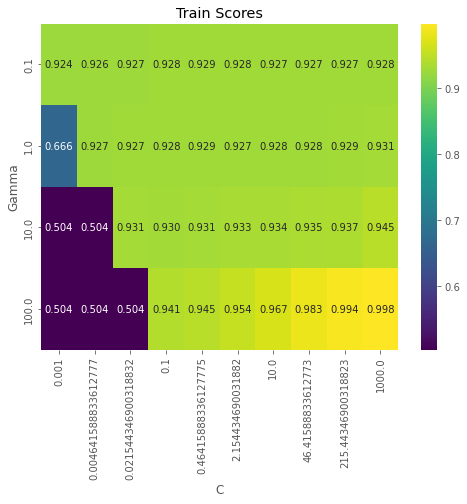

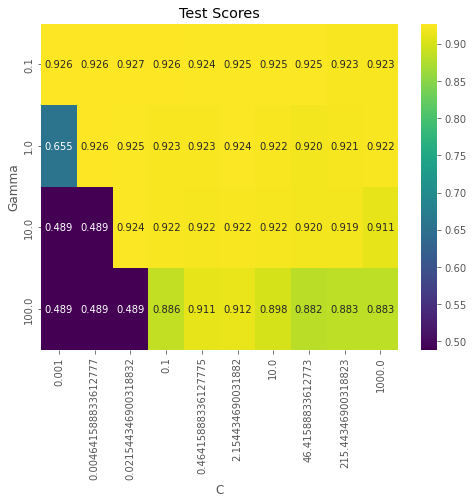

In [ ]:
import seaborn as sns
import pandas as pd
gammas = [0.1, 1, 10, 100]

# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
X_train_ov, X_test_ov, y_train_ov, y_test_ov = train_test_split(X_overlap, y_overlap, test_size=0.25, random_state=0)

# Initialize an empty dataframe to store the results
results = []

# Train SVM with Gaussian kernel using different values of gamma and C
for gamma in gammas:
    for c in np.logspace(-3, 3, 10):
        clf = SVC(kernel='rbf', gamma=gamma, C=c)
        clf.fit(X_train_ov, y_train_ov)

        train_score = clf.score(X_train_ov, y_train_ov)
        test_score = clf.score(X_test_ov, y_test_ov)
        print(f'Gamma: {gamma}, C: {c} | Train score: {train_score}, Test score: {test_score}')
        results.append({'Gamma': gamma, 'C': c, 'Train score': train_score, 'Test score': test_score})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Create a heatmap for train scores
plt.figure(figsize=(8, 6))
sns.heatmap(results_df.pivot('Gamma', 'C', 'Train score'), annot=True, fmt='.3f', cmap='viridis')
plt.title('Train Scores')
plt.show()

# Create a heatmap for test scores
plt.figure(figsize=(8, 6))
sns.heatmap(results_df.pivot('Gamma', 'C', 'Test score'), annot=True, fmt='.3f', cmap='viridis')
plt.title('Test Scores')
plt.show()


Indeed, we can see that for a big  Gamma and C we end up with higher train scores but lower test scores, which is an indication that we are in a case of overfitted data.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

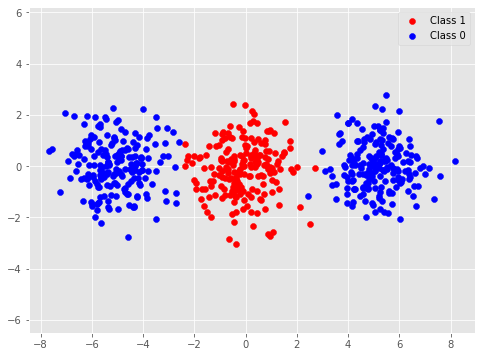

In [ ]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0
# Define three centers for the classes (Class 0 - Class 1 - Class 0)
centers = [(-5, 0), (0, 0), (5, 0)]

# Generate a non-linearly separable dataset using make_blobs
X_nl, y_nl = make_blobs(n_samples=600, centers=centers, random_state=0)

# Adjust the labels to make it a binary classification problem
y_nl = np.where(y_nl == 2, 0, y_nl)

# Plot the dataset
plt.figure(figsize=(8, 6))
pos_nl = np.where(y_nl == 1)[0]
neg_nl = np.where(y_nl == 0)[0]
plt.scatter(X_nl[pos_nl, 0], X_nl[pos_nl, 1], c='r', label='Class 1')
plt.scatter(X_nl[neg_nl, 0], X_nl[neg_nl, 1], c='b', label='Class 0')
plt.axis('equal')
plt.legend()
plt.show()


**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

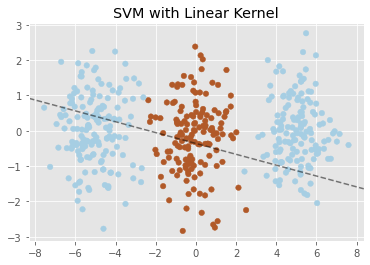

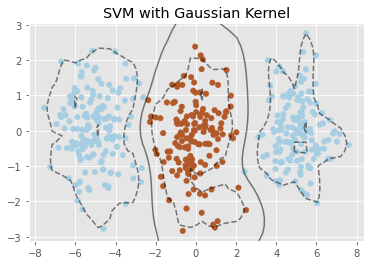

In [ ]:
# Use the code of question 6 again

# Split the non-linear dataset into training and testing sets
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl, y_nl, test_size=0.25, random_state=42)

# Define the parameters for GridSearchCV
params_linear = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
params_rbf = {'kernel': ['rbf'], 'C': list(np.logspace(-3, 3, 5)), 'gamma': [0.1, 1, 10, 100]}

# Linear SVM
grid_linear = GridSearchCV(SVC(), params_linear)
grid_linear.fit(X_train_nl, y_train_nl)

# Gaussian SVM
grid_rbf = GridSearchCV(SVC(), params_rbf)
grid_rbf.fit(X_train_nl, y_train_nl)

# Plot the decision boundaries
def plot_decision_boundary(clf, X, y, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.title(title)
    plt.show()

# Linear kernel
plot_decision_boundary(grid_linear.best_estimator_, X_train_nl, y_train_nl, 'SVM with Linear Kernel')

# Gaussian kernel
plot_decision_boundary(grid_rbf.best_estimator_, X_train_nl, y_train_nl, 'SVM with Gaussian Kernel')


## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance.
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

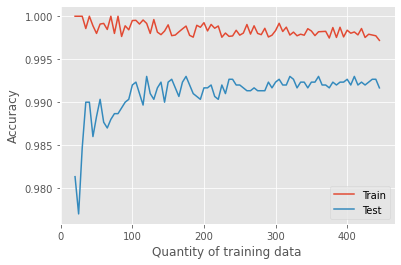

In [ ]:
# Total number of training samples
n_tr = len(X_train_nl)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times
n_m = 20

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=0)
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train_nl[idx, :]
        y_train_reduced = y_train_nl[idx]

        # Fit the classifier and compute the scores on training and test data
        svm.fit(X_train_reduced, y_train_reduced)
        score_train += svm.score(X_train_reduced, y_train_reduced)
        score_test += svm.score(X_test_nl, y_test_nl)
    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4).
n_mc = 1000 # Repeat this n_mc times - enough to approximate
expectation = 0
cov = np.eye(2) #standard deviation = 1
for i in range(n_mc):
    rand = np.random.randint(3)# Random binary choice: will the point be generated from the first or second gaussian?
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal((centers[0]),cov)
    elif rand ==1 :
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1],cov)
    else :
        x = np.random.multivariate_normal(centers[2],cov)


    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x,mean = centers[0], cov=cov)
    p2 = multivariate_normal.pdf(x,mean = centers[1], cov=cov)
    p3 = multivariate_normal.pdf(x,mean = centers[2], cov=cov)
    # Compute the risk from these and add it to the total
    risk = min((p1+p3)/(p1+p2+p3), p2/(p1+p2+p3))
    expectation += risk

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.008
Estimated Bayes accuracy: 0.992


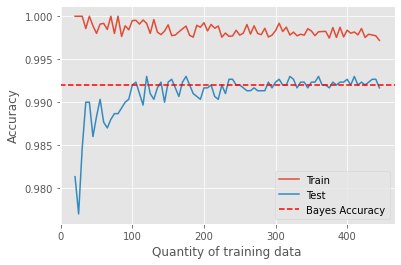

In [ ]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')

plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')
plt.axhline(y= 1 - np.around(expectation,3), color='r', linestyle='--', label='Bayes Accuracy')
plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div> We can see that the Train curve is almost a line, as it was the data we used for the training. The test one grows with the ammount of data used for the training, untill it hits a cap, that is the Bayes Accuracy, then it stays around this value.

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

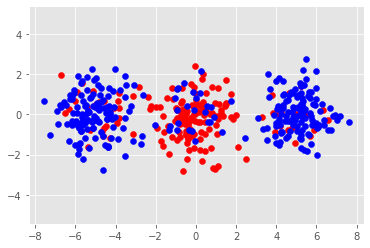

In [ ]:
# Modify the class of some data points randomly
n_noise = 10
n_tr = len(y_train_nl)
idx = np.random.choice(range(n_tr), n_noise)
y_train_nl[idx] = 1 - y_train_nl[idx]

pos = np.where(y_train_nl == 1)[0]
neg = np.where(y_train_nl == 0)[0]

# Visualise the data
plt.scatter(X_train_nl[pos,0], X_train_nl[pos,1], c='r')
plt.scatter(X_train_nl[neg,0], X_train_nl[neg,1], c='b')
plt.axis('equal')
plt.show()

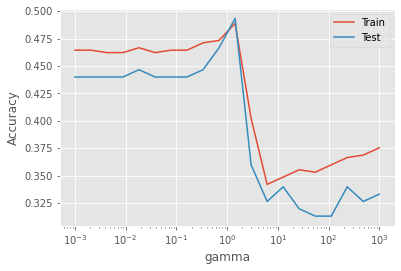

In [ ]:
# Vary the appropriate parameter and plot the training/testing results
# Define a range of values for the hyperparameter C
gammas = np.logspace(-3, 3, 20)

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the value of C
for gamma in gammas:
    # Create a SVM with the current value of C
    svm = SVC(kernel='rbf', C=0.5, gamma=gamma, random_state=0)

    # Fit the classifier and compute the scores on training and test data
    svm.fit(X_train, y_train)
    score_train = svm.score(X_train_nl, y_train_nl)
    score_test = svm.score(X_test_nl, y_test_nl)

    # Add the scores to the lists
    scores_train.append(score_train)
    scores_test.append(score_test)

# Plot the results
plt.plot(gammas, scores_train, label='Train')
plt.plot(gammas, scores_test, label='Test')
plt.xscale('log')
plt.xlabel('gamma')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

<div class='alert alert-block alert-warning'>
            Answer:</div> We can see that the accuracy mantains it's accuracy in a certain range, then, for a certain Gamma, we probably started to overfit the data, leading for a fall in the Accuracy. Also the accuracy is much lower than the case of non noise, what is expected, as we switched a significant ammount of points.